# WEEK 1

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pickle
import numpy as np
import cv2
from tqdm import tqdm
from itertools import product, combinations_with_replacement
import json


from histograms import *
from similarity_measures_optimized import *
from mapk import *
from helper_functions_main import *

## Histogram Definitions and Data Extraction

### Calculate all the historgrams for the images in train and query sets

In [2]:
# Paths
train_directory = "../Data/BBDD/"
query_directory = "../Data/Week1/qsd1_w1/"

# Get image file lists (keep order as-is to match indices across runs)
train_images = [f for f in os.listdir(train_directory) if f.endswith('.jpg')]
query_images = [f for f in os.listdir(query_directory) if f.endswith('.jpg')]

# Lists for all histograms
train_rgb_mean_histograms = []
train_rgb_concat_histograms = []
train_hsv_concat_histograms = []
train_lab_concat_histograms = []
train_ycbcr_concat_histograms = []
train_xyz_concat_histograms = []
train_hls_concat_histograms = []
train_yuv_concat_histograms = []
train_gray_histograms = []

query_rgb_mean_histograms = []
query_rgb_concat_histograms = []
query_hsv_concat_histograms = []
query_lab_concat_histograms = []
query_ycbcr_concat_histograms = []
query_xyz_concat_histograms = []
query_hls_concat_histograms = []
query_yuv_concat_histograms = []
query_gray_histograms = []

# Cache setup
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
cache_path = os.path.join(cache_dir, "histograms_v1.pkl")

loaded_from_cache = False
if os.path.exists(cache_path):
    try:
        with open(cache_path, "rb") as f:
            cache = pickle.load(f)
        # Validate that image lists match (order-sensitive)
        if cache.get('train_images') == train_images and cache.get('query_images') == query_images:
            train_rgb_mean_histograms = cache['train_rgb_mean_histograms']
            train_rgb_concat_histograms = cache['train_rgb_concat_histograms']
            train_hsv_concat_histograms = cache['train_hsv_concat_histograms']
            train_lab_concat_histograms = cache['train_lab_concat_histograms']
            train_ycbcr_concat_histograms = cache['train_ycbcr_concat_histograms']
            train_xyz_concat_histograms = cache['train_xyz_concat_histograms']
            train_hls_concat_histograms = cache['train_hls_concat_histograms']
            train_yuv_concat_histograms = cache['train_yuv_concat_histograms']
            train_gray_histograms = cache['train_gray_histograms']

            query_rgb_mean_histograms = cache['query_rgb_mean_histograms']
            query_rgb_concat_histograms = cache['query_rgb_concat_histograms']
            query_hsv_concat_histograms = cache['query_hsv_concat_histograms']
            query_lab_concat_histograms = cache['query_lab_concat_histograms']
            query_ycbcr_concat_histograms = cache['query_ycbcr_concat_histograms']
            query_xyz_concat_histograms = cache['query_xyz_concat_histograms']
            query_hls_concat_histograms = cache['query_hls_concat_histograms']
            query_yuv_concat_histograms = cache['query_yuv_concat_histograms']
            query_gray_histograms = cache['query_gray_histograms']
            loaded_from_cache = True
            print(f"Loaded histograms from cache: {cache_path}")
        else:
            print("Cache found but image lists differ from current folders. Recomputing histograms...")
    except Exception as e:
        print(f"Failed to load cache ({e}). Recomputing histograms...")


if not loaded_from_cache:
    # ---------- Train set ----------
    for img_name in tqdm(train_images, desc="Processing train images"):
        img_pil = Image.open(os.path.join(train_directory, img_name))
        img_cv = pil_to_cv2(img_pil)
        height, width = img_cv.shape[:2]

        # RGB Mean Histogram
        rgb_mean_hist = RGB_Mean_Histogram(height, width)
        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        for i, color in enumerate(["red", "green", "blue"]):
            channel = img_rgb[:,:,i].flatten()
            hist = np.bincount(channel, minlength=256)
            rgb_mean_hist.setHist(color, hist)
        rgb_mean_hist.calculate_1D_hist()
        rgb_mean_hist.normalize()
        train_rgb_mean_histograms.append(copy.copy(rgb_mean_hist))

        # RGB Concat Histogram
        rgb_concat_hist = RGB_Concat_Histogram(height, width)
        for i, color in enumerate(["red", "green", "blue"]):
            channel = img_rgb[:,:,i].flatten()
            hist = np.bincount(channel, minlength=256)
            rgb_concat_hist.setHist(color, hist)
        rgb_concat_hist.calculate_concat_hist()
        rgb_concat_hist.normalize()
        train_rgb_concat_histograms.append(copy.copy(rgb_concat_hist))

        # HSV Concat Histogram
        hsv_concat_hist = HSV_Concat_Histogram(height, width)
        img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
        h_hist = np.bincount(img_hsv[:,:,0].flatten(), minlength=256)
        s_hist = np.bincount(img_hsv[:,:,1].flatten(), minlength=256)
        v_hist = np.bincount(img_hsv[:,:,2].flatten(), minlength=256)
        hsv_concat_hist.setHist(h_hist, s_hist, v_hist)
        hsv_concat_hist.calculate_concat_hist()
        hsv_concat_hist.normalize()
        train_hsv_concat_histograms.append(copy.copy(hsv_concat_hist))

        # CIELAB Concat Histogram
        lab_concat_hist = CIELAB_Concat_Histogram(height, width)
        img_lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
        l_hist = np.bincount(img_lab[:,:,0].flatten(), minlength=256)
        a_hist = np.bincount(img_lab[:,:,1].flatten(), minlength=256)
        b_hist = np.bincount(img_lab[:,:,2].flatten(), minlength=256)
        lab_concat_hist.setHist(l_hist, a_hist, b_hist)
        lab_concat_hist.calculate_concat_hist()
        lab_concat_hist.normalize()
        train_lab_concat_histograms.append(copy.copy(lab_concat_hist))

        # YCbCr Concat Histogram
        ycbcr_concat_hist = YCbCr_Concat_Histogram(height, width)
        img_ycbcr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YCrCb)
        y_hist = np.bincount(img_ycbcr[:,:,0].flatten(), minlength=256)
        cb_hist = np.bincount(img_ycbcr[:,:,1].flatten(), minlength=256)
        cr_hist = np.bincount(img_ycbcr[:,:,2].flatten(), minlength=256)
        ycbcr_concat_hist.setHist(y_hist, cb_hist, cr_hist)
        ycbcr_concat_hist.calculate_concat_hist()
        ycbcr_concat_hist.normalize()
        train_ycbcr_concat_histograms.append(copy.copy(ycbcr_concat_hist))
                
        # XYZ Concat Histogram
        xyz_concat_hist = XYZ_Concat_Histogram(height, width)
        img_xyz = cv2.cvtColor(img_cv, cv2.COLOR_BGR2XYZ)
        x_hist = np.bincount(img_xyz[:,:,0].flatten(), minlength=256)
        y_hist = np.bincount(img_xyz[:,:,1].flatten(), minlength=256)
        z_hist = np.bincount(img_xyz[:,:,2].flatten(), minlength=256)
        xyz_concat_hist.setHist(x_hist, y_hist, z_hist)
        xyz_concat_hist.calculate_concat_hist()
        xyz_concat_hist.normalize()
        train_xyz_concat_histograms.append(copy.copy(xyz_concat_hist))
        
        # HLS Concat Histogram
        hls_concat_hist = HLS_Concat_Histogram(height, width)
        img_hls = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HLS)
        h_hist = np.bincount(img_hls[:,:,0].flatten(), minlength=256)
        l_hist = np.bincount(img_hls[:,:,1].flatten(), minlength=256)
        s_hist = np.bincount(img_hls[:,:,2].flatten(), minlength=256)
        hls_concat_hist.setHist(h_hist, l_hist, s_hist)
        hls_concat_hist.calculate_concat_hist()
        hls_concat_hist.normalize()
        train_hls_concat_histograms.append(copy.copy(hls_concat_hist))
        
        # YUV Concat Histogram
        yuv_concat_hist = YUV_Concat_Histogram(height, width)
        img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
        y_hist = np.bincount(img_yuv[:,:,0].flatten(), minlength=256)
        u_hist = np.bincount(img_yuv[:,:,1].flatten(), minlength=256)
        v_hist = np.bincount(img_yuv[:,:,2].flatten(), minlength=256)
        yuv_concat_hist.setHist(y_hist, u_hist, v_hist)
        yuv_concat_hist.calculate_concat_hist()
        yuv_concat_hist.normalize()
        train_yuv_concat_histograms.append(copy.copy(yuv_concat_hist))

        # Gray Histogram
        gray_hist = Gray_Histogram(width, height)
        img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        gray_hist.setHist(np.bincount(img_gray.flatten(), minlength=256))
        gray_hist.normalize()
        train_gray_histograms.append(copy.copy(gray_hist))

    # ---------- Query set ----------
    for img_name in tqdm(query_images, desc="Processing query images"):
        img_pil = Image.open(os.path.join(query_directory, img_name))
        img_cv = pil_to_cv2(img_pil)
        height, width = img_cv.shape[:2]

        # RGB Mean Histogram        
        rgb_mean_hist = RGB_Mean_Histogram(height, width)
        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        for i, color in enumerate(["red", "green", "blue"]):
            channel = img_rgb[:,:,i].flatten()
            hist = np.bincount(channel, minlength=256)
            rgb_mean_hist.setHist(color, hist)
        rgb_mean_hist.calculate_1D_hist()
        rgb_mean_hist.normalize()
        query_rgb_mean_histograms.append(copy.copy(rgb_mean_hist))


        # RGB Concat Histogram
        rgb_concat_hist = RGB_Concat_Histogram(height, width)
        for i, color in enumerate(["red", "green", "blue"]):
            channel = img_rgb[:,:,i].flatten()
            hist = np.bincount(channel, minlength=256)
            rgb_concat_hist.setHist(color, hist)
        rgb_concat_hist.calculate_concat_hist()
        rgb_concat_hist.normalize()
        query_rgb_concat_histograms.append(copy.copy(rgb_concat_hist))

        # HSV Concat Histogram
        hsv_concat_hist = HSV_Concat_Histogram(height, width)
        img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
        h_hist = np.bincount(img_hsv[:,:,0].flatten(), minlength=256)
        s_hist = np.bincount(img_hsv[:,:,1].flatten(), minlength=256)
        v_hist = np.bincount(img_hsv[:,:,2].flatten(), minlength=256)
        hsv_concat_hist.setHist(h_hist, s_hist, v_hist)
        hsv_concat_hist.calculate_concat_hist()
        hsv_concat_hist.normalize()
        query_hsv_concat_histograms.append(copy.copy(hsv_concat_hist))

        # CIELAB Concat Histogram
        lab_concat_hist = CIELAB_Concat_Histogram(height, width)
        img_lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
        l_hist = np.bincount(img_lab[:,:,0].flatten(), minlength=256)
        a_hist = np.bincount(img_lab[:,:,1].flatten(), minlength=256)
        b_hist = np.bincount(img_lab[:,:,2].flatten(), minlength=256)
        lab_concat_hist.setHist(l_hist, a_hist, b_hist)
        lab_concat_hist.calculate_concat_hist()
        lab_concat_hist.normalize()
        query_lab_concat_histograms.append(copy.copy(lab_concat_hist))

        # YCbCr Concat Histogram
        ycbcr_concat_hist = YCbCr_Concat_Histogram(height, width)
        img_ycbcr = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YCrCb)
        y_hist = np.bincount(img_ycbcr[:,:,0].flatten(), minlength=256)
        cb_hist = np.bincount(img_ycbcr[:,:,1].flatten(), minlength=256)
        cr_hist = np.bincount(img_ycbcr[:,:,2].flatten(), minlength=256)
        ycbcr_concat_hist.setHist(y_hist, cb_hist, cr_hist)
        ycbcr_concat_hist.calculate_concat_hist()
        ycbcr_concat_hist.normalize()
        query_ycbcr_concat_histograms.append(copy.copy(ycbcr_concat_hist))

        # XYZ Concat Histogram
        xyz_concat_hist = XYZ_Concat_Histogram(height, width)
        img_xyz = cv2.cvtColor(img_cv, cv2.COLOR_BGR2XYZ)
        x_hist = np.bincount(img_xyz[:,:,0].flatten(), minlength=256)
        y_hist = np.bincount(img_xyz[:,:,1].flatten(), minlength=256)
        z_hist = np.bincount(img_xyz[:,:,2].flatten(), minlength=256)
        xyz_concat_hist.setHist(x_hist, y_hist, z_hist)
        xyz_concat_hist.calculate_concat_hist()
        xyz_concat_hist.normalize()
        query_xyz_concat_histograms.append(copy.copy(xyz_concat_hist))
        
        # HLS Concat Histogram
        hls_concat_hist = HLS_Concat_Histogram(height, width)
        img_hls = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HLS)
        h_hist = np.bincount(img_hls[:,:,0].flatten(), minlength=256)
        l_hist = np.bincount(img_hls[:,:,1].flatten(), minlength=256)
        s_hist = np.bincount(img_hls[:,:,2].flatten(), minlength=256)
        hls_concat_hist.setHist(h_hist, l_hist, s_hist)
        hls_concat_hist.calculate_concat_hist()
        hls_concat_hist.normalize()
        query_hls_concat_histograms.append(copy.copy(hls_concat_hist))
        
        # YUV Concat Histogram
        yuv_concat_hist = YUV_Concat_Histogram(height, width)
        img_yuv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2YUV)
        y_hist = np.bincount(img_yuv[:,:,0].flatten(), minlength=256)
        u_hist = np.bincount(img_yuv[:,:,1].flatten(), minlength=256)
        v_hist = np.bincount(img_yuv[:,:,2].flatten(), minlength=256)
        yuv_concat_hist.setHist(y_hist, u_hist, v_hist)
        yuv_concat_hist.calculate_concat_hist()
        yuv_concat_hist.normalize()
        query_yuv_concat_histograms.append(copy.copy(yuv_concat_hist))

        # Gray Histogram
        gray_hist = Gray_Histogram(width, height)
        img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        gray_hist.setHist(np.bincount(img_gray.flatten(), minlength=256))
        gray_hist.normalize()
        query_gray_histograms.append(copy.copy(gray_hist))

    # Save to cache
    cache = {
        'version': 1,
        'train_images': train_images,
        'query_images': query_images,
        'train_rgb_mean_histograms': train_rgb_mean_histograms,
        'train_rgb_concat_histograms': train_rgb_concat_histograms,
        'train_hsv_concat_histograms': train_hsv_concat_histograms,
        'train_lab_concat_histograms': train_lab_concat_histograms,
        'train_ycbcr_concat_histograms': train_ycbcr_concat_histograms,
        'train_xyz_concat_histograms': train_xyz_concat_histograms,
        'train_hls_concat_histograms': train_hls_concat_histograms,
        'train_yuv_concat_histograms': train_yuv_concat_histograms,
        'train_gray_histograms': train_gray_histograms,
        'query_rgb_mean_histograms': query_rgb_mean_histograms,
        'query_rgb_concat_histograms': query_rgb_concat_histograms,
        'query_hsv_concat_histograms': query_hsv_concat_histograms,
        'query_lab_concat_histograms': query_lab_concat_histograms,
        'query_ycbcr_concat_histograms': query_ycbcr_concat_histograms,
        'query_xyz_concat_histograms': query_xyz_concat_histograms,
        'query_hls_concat_histograms': query_hls_concat_histograms,
        'query_yuv_concat_histograms': query_yuv_concat_histograms,
        'query_gray_histograms': query_gray_histograms,
    }
    with open(cache_path, "wb") as f:
        pickle.dump(cache, f)
    print(f"Computed histograms and saved cache to: {cache_path}")

Loaded histograms from cache: cache\histograms_v1.pkl


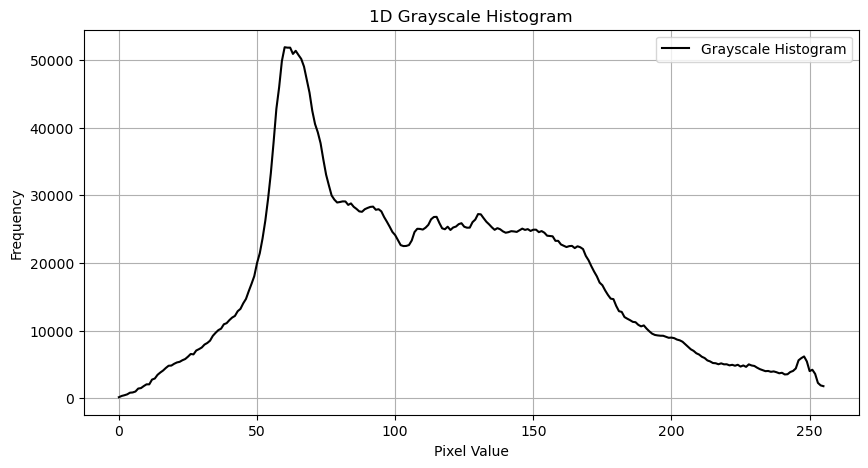

In [3]:
# Show example histograms for query image 3
#train_rgb_mean_histograms[2].show()
#train_rgb_concat_histograms[2].show()
#train_hsv_concat_histograms[2].show()
#train_lab_concat_histograms[2].show()
#train_ycbcr_concat_histograms[2].show()
train_gray_histograms[3].show()

## Parameter Search

We try the following approaches:
1. For each descriptor use one individual similarity measure
2. Find a ponderation between descriptors and similarity measures (Only try combination of the best P descriptors and M measures from the experiment 1 to make it computationally viable). Choose the best two algorithms (using different descriptors)
3. For the best two algorithms found in experiment 2, try different bin counts for the histograms to see if we can improve the results

In [4]:
with open("../Data/Week1/qsd1_w1/gt_corresps.pkl", "rb") as f:
    gt_data = pickle.load(f)

train_rgb_mean_hists = extract_histograms(train_rgb_mean_histograms)
query_rgb_mean_hists = extract_histograms(query_rgb_mean_histograms)
train_rgb_concat_hists = extract_histograms(train_rgb_concat_histograms)
query_rgb_concat_hists = extract_histograms(query_rgb_concat_histograms)
train_hsv_concat_hists = extract_histograms(train_hsv_concat_histograms)
query_hsv_concat_hists = extract_histograms(query_hsv_concat_histograms)
train_lab_concat_hists = extract_histograms(train_lab_concat_histograms)
query_lab_concat_hists = extract_histograms(query_lab_concat_histograms)
train_ycbcr_concat_hists = extract_histograms(train_ycbcr_concat_histograms)
query_ycbcr_concat_hists = extract_histograms(query_ycbcr_concat_histograms)
train_xyz_concat_hists = extract_histograms(train_xyz_concat_histograms)
query_xyz_concat_hists = extract_histograms(query_xyz_concat_histograms)
train_hls_concat_hists = extract_histograms(train_hls_concat_histograms)
query_hls_concat_hists = extract_histograms(query_hls_concat_histograms)
train_yuv_concat_hists = extract_histograms(train_yuv_concat_histograms)
query_yuv_concat_hists = extract_histograms(query_yuv_concat_histograms)
train_gray_hists = extract_histograms(train_gray_histograms)
query_gray_hists = extract_histograms(query_gray_histograms)

similarity_matrix_funcs = [
    euclidean_distance_matrix,
    l1_distance_matrix,
    x2_distance_matrix,
    histogram_intersection_matrix,
    hellinger_kernel_matrix,
    cosine_similarity_matrix,
    bhattacharyya_distance_matrix,
    correlation_matrix,
    kl_divergence_matrix,
    canberra_distance_matrix
    # emd_matrix
]

similarity_names = ["Euclidean", "L1", "Chi^2", "Hist. Intersection", "Hellinger", "Cosine", "Bhattacharyya", "Correlation", "KL Divergence", "Canberra"]#, "EMD"]
descriptor_names = [
    "RGB Mean Histogram",
    "RGB Concat Histogram",
    "HSV Concat Histogram",
    "CIELAB Concat Histogram",
    "YCbCr Concat Histogram",
    "XYZ Concat Histogram",
    "HLS Concat Histogram",
    "YUV Concat Histogram",
    "Gray Histogram"
]
descriptor_pairs = [
    (query_rgb_mean_hists, train_rgb_mean_hists),
    (query_rgb_concat_hists, train_rgb_concat_hists),
    (query_hsv_concat_hists, train_hsv_concat_hists),
    (query_lab_concat_hists, train_lab_concat_hists),
    (query_ycbcr_concat_hists, train_ycbcr_concat_hists),
    (query_xyz_concat_hists, train_xyz_concat_hists),
    (query_hls_concat_hists, train_hls_concat_hists),
    (query_yuv_concat_hists, train_yuv_concat_hists),
    (query_gray_hists, train_gray_hists)
]

In [5]:
# sim_scores[d_idx][q_idx][t_idx][f_idx]: descriptor, query, train, similarity
sim_scores = []
for d_idx, (query_hists, train_hists) in enumerate(descriptor_pairs):
    desc_scores = np.zeros((len(query_hists), len(train_hists), len(similarity_matrix_funcs)))
    Q = np.array([normalize_hist(h) for h in query_hists])
    M = np.array([normalize_hist(h) for h in train_hists])
    for f_idx, func in enumerate(similarity_matrix_funcs):
        D = func(Q, M)
        # If similarity (intersection/hellinger), invert sign for sorting later
        if func.__name__ in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
            D = -D
        desc_scores[:, :, f_idx] = D
    sim_scores.append(desc_scores)

### Experiment 1: Compare descriptors and similarity measures

In [6]:
results_matrix = np.zeros((len(descriptor_names), len(similarity_matrix_funcs)))
TOP_K = 5

for d_idx in range(len(descriptor_names)):
    desc_scores = sim_scores[d_idx]  # scores for a specific descriptor
    for f_idx in range(len(similarity_matrix_funcs)):
        # For each query image, retrieve the indices of the TOP_K most similar train images
        predicted = []
        for q_idx in range(desc_scores.shape[0]):
            scores = desc_scores[q_idx, :, f_idx]
            top_indices = np.argsort(scores)[:TOP_K]
            predicted.append(list(top_indices))

        score = mapk(gt_data, predicted, k=TOP_K)
        results_matrix[d_idx, f_idx] = score

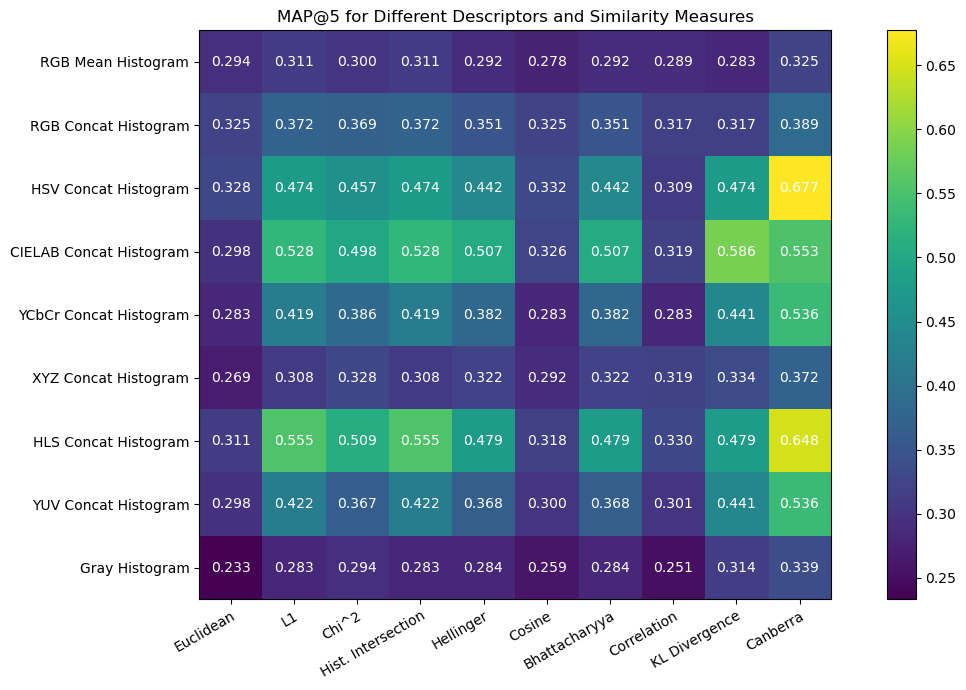

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(results_matrix, cmap="viridis")

# Show all ticks and label them
ax.set_xticks(np.arange(len(similarity_names)))
ax.set_yticks(np.arange(len(descriptor_names)))
ax.set_xticklabels(similarity_names)
ax.set_yticklabels(descriptor_names)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Loop over data to create text annotations
for i in range(len(descriptor_names)):
    for j in range(len(similarity_names)):
        text = ax.text(j, i, f"{results_matrix[i, j]:.3f}",
                       ha="center", va="center", color="w")

ax.set_title("MAP@5 for Different Descriptors and Similarity Measures")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

### Experiment 2: Combine two descriptors and all similarity scores by weights 

In [8]:
# Experiment 2: Find best two algorithms (each: two descriptors + weights, no identical pairs; one descriptor can be repeated)
TOP_K = 5
weight_steps = [0, 0.5, 1]
P_descriptors = 5 # Number of descriptors to combine
M_measures = 3    # Number of similarity measures to combine

try:
    desc_rank = np.argsort(-results_matrix.mean(axis=1))[:P_descriptors]
    sim_scores_by_measure = results_matrix[:, :]
    sim_rank = np.argsort(-sim_scores_by_measure.mean(axis=0))[:M_measures]
except Exception:
    desc_rank = np.arange(min(P_descriptors, len(descriptor_names)))
    sim_rank = np.arange(min(M_measures, len(similarity_matrix_funcs)))

descriptor_indices = list(desc_rank)
all_exp2_results = []
descriptor_pairs = list(combinations_with_replacement(descriptor_indices, 2))

for d_pair in descriptor_pairs:
    d1, d2 = d_pair
    desc_scores_1 = sim_scores[d1][:, :, sim_rank]
    desc_scores_2 = sim_scores[d2][:, :, sim_rank]
    n_weights = len(sim_rank)
    for weights1 in product(weight_steps, repeat=n_weights):
        weights1 = np.array(weights1)
        if not np.any(weights1):
            continue
        for weights2 in product(weight_steps, repeat=n_weights):
            weights2 = np.array(weights2)
            if not np.any(weights2):
                continue
            weighted1 = np.dot(desc_scores_1, weights1)
            weighted2 = np.dot(desc_scores_2, weights2)
            combined = (weighted1 + weighted2) / 2.0
            predicted = [list(np.argsort(combined[q_idx])[:TOP_K]) for q_idx in range(combined.shape[0])]
            score = mapk(gt_data, predicted, k=TOP_K)
            # Store sorted tuple for pair uniqueness
            pair_key = tuple(sorted((int(d1), int(d2))))
            all_exp2_results.append((float(score), pair_key, (int(d1), int(d2)), weights1.astype(float).tolist(), weights2.astype(float).tolist()))

# Select best two algorithms, ensuring the descriptor pairs are not identical (one can be repeated, not both)
all_exp2_results.sort(reverse=True, key=lambda x: x[0])
best_two_results = []
selected_pair_keys = set()
for score, pair_key, d_pair, weights1, weights2 in all_exp2_results:
    if pair_key not in selected_pair_keys:
        best_two_results.append((score, d_pair, weights1, weights2))
        selected_pair_keys.add(pair_key)
    if len(best_two_results) == 2:
        break

print("Best two algorithms (each: two descriptors + weights):")
for i, (score, d_pair, weights1, weights2) in enumerate(best_two_results):
    d1, d2 = d_pair
    print(f"{i+1}. {descriptor_names[d1]} + {descriptor_names[d2]} | MAP@{TOP_K}: {score:.3f}")
    print(f"   Weights1: {np.round(weights1, 3)} | Weights2: {np.round(weights2, 3)}")

Best two algorithms (each: two descriptors + weights):
1. CIELAB Concat Histogram + HSV Concat Histogram | MAP@5: 0.689
   Weights1: [0.5 0.  0. ] | Weights2: [1. 0. 0.]
2. HLS Concat Histogram + HSV Concat Histogram | MAP@5: 0.680
   Weights1: [0.5 0.  0. ] | Weights2: [0.5 1.  0.5]


### Experiment 3: Bin count sweep for the best combo from Experiment 3

In [9]:
# Experiment 3: Bin count sweep for the best two algorithms from Experiment 2 (each: two descriptors + weights)

bin_counts = [8, 16, 32, 64, 128, 256]
TOP_K = 5

def get_histograms_by_index(idx):
    if idx == 0:
        return query_rgb_mean_histograms, train_rgb_mean_histograms
    elif idx == 1:
        return query_rgb_concat_histograms, train_rgb_concat_histograms
    elif idx == 2:
        return query_hsv_concat_histograms, train_hsv_concat_histograms
    elif idx == 3:
        return query_lab_concat_histograms, train_lab_concat_histograms
    elif idx == 4:
        return query_ycbcr_concat_histograms, train_ycbcr_concat_histograms
    elif idx == 5:
        return query_xyz_concat_histograms, train_xyz_concat_histograms
    elif idx == 6:
        return query_hls_concat_histograms, train_hls_concat_histograms
    elif idx == 7:
        return query_yuv_concat_histograms, train_yuv_concat_histograms
    elif idx == 8:
        return query_gray_histograms, train_gray_histograms
    else:
        raise ValueError('Invalid descriptor index')

# Store results for summary
exp3_matrix = np.zeros((2, len(bin_counts))) # 2 algorithms x bin counts
alg_labels = []
best_scores = [-1, -1]
best_params = [{}, {}]
best_bins = [None, None]

for idx, (score, d_pair, weights1, weights2) in enumerate(best_two_results):
    d1, d2 = d_pair
    label1 = f"{descriptor_names[d1]} ({np.round(weights1, 2)})"
    label2 = f"{descriptor_names[d2]} ({np.round(weights2, 2)})"
    alg_labels.append(f"{label1}\n{label2}")
    for j, bins in enumerate(bin_counts):
        q1, t1 = get_histograms_by_index(d1)
        q2, t2 = get_histograms_by_index(d2)
        q_bins1 = [create_histogram_with_bins(h, bins) for h in q1]
        t_bins1 = [create_histogram_with_bins(h, bins) for h in t1]
        q_bins2 = [create_histogram_with_bins(h, bins) for h in q2]
        t_bins2 = [create_histogram_with_bins(h, bins) for h in t2]
        Q1 = np.array([normalize_hist(h) for h in q_bins1])
        M1 = np.array([normalize_hist(h) for h in t_bins1])
        Q2 = np.array([normalize_hist(h) for h in q_bins2])
        M2 = np.array([normalize_hist(h) for h in t_bins2])
        desc_scores1 = np.stack([similarity_matrix_funcs[i](Q1, M1) for i in sim_rank], axis=-1)
        desc_scores2 = np.stack([similarity_matrix_funcs[i](Q2, M2) for i in sim_rank], axis=-1)
        for i, sim_idx in enumerate(sim_rank):
            func = similarity_matrix_funcs[sim_idx]
            if func.__name__ in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
                desc_scores1[:, :, i] = -desc_scores1[:, :, i]
                desc_scores2[:, :, i] = -desc_scores2[:, :, i]
        weighted1 = np.dot(desc_scores1, np.asarray(weights1, dtype=float))
        weighted2 = np.dot(desc_scores2, np.asarray(weights2, dtype=float))
        combined = (weighted1 + weighted2) / 2.0
        predicted = [list(np.argsort(combined[q_idx])[:TOP_K]) for q_idx in range(combined.shape[0])]
        score_bins = mapk(gt_data, predicted, k=TOP_K)
        exp3_matrix[idx, j] = score_bins
        if score_bins > best_scores[idx]:
            best_scores[idx] = score_bins
            best_bins[idx] = bins
            best_params[idx] = {
                'algorithm': idx+1,
                'descriptors': (descriptor_names[d1], descriptor_names[d2]),
                'weights1': np.round(weights1, 3).tolist(),
                'weights2': np.round(weights2, 3).tolist(),
                'bins': bins,
                'MAP@K': score_bins
            }

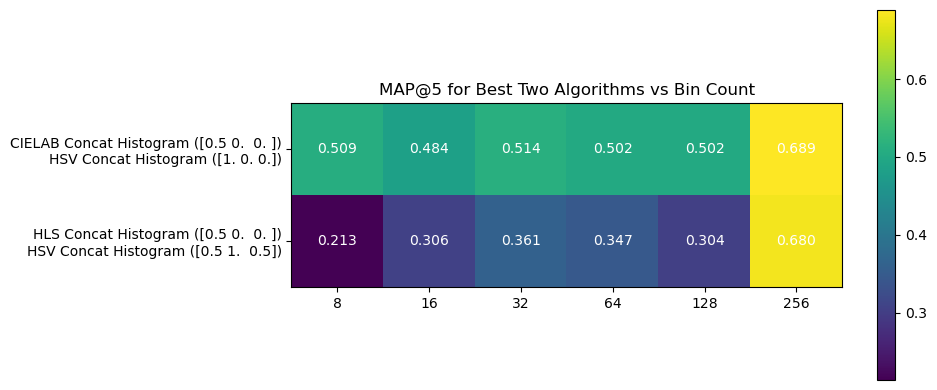

In [10]:
# Show results as heatmap with two-line labels
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(exp3_matrix, cmap="viridis")
ax.set_xticks(np.arange(len(bin_counts)))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(bin_counts)
ax.set_yticklabels(alg_labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
for i in range(2):
    for j in range(len(bin_counts)):
        text = ax.text(j, i, f"{exp3_matrix[i, j]:.3f}", ha="center", va="center", color="w")
ax.set_title("MAP@5 for Best Two Algorithms vs Bin Count")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Calculate final MAP@5 and MAP@1 for the best algorithms with their optimal bins
print('Final results for the best two algorithms:')
for idx, (score, d_pair, weights1, weights2) in enumerate(best_two_results):
    d1, d2 = d_pair
    bins = best_bins[idx]
    
    # Recalculate with optimal bins
    q1, t1 = get_histograms_by_index(d1)
    q2, t2 = get_histograms_by_index(d2)
    q_bins1 = [create_histogram_with_bins(h, bins) for h in q1]
    t_bins1 = [create_histogram_with_bins(h, bins) for h in t1]
    q_bins2 = [create_histogram_with_bins(h, bins) for h in q2]
    t_bins2 = [create_histogram_with_bins(h, bins) for h in t2]
    Q1 = np.array([normalize_hist(h) for h in q_bins1])
    M1 = np.array([normalize_hist(h) for h in t_bins1])
    Q2 = np.array([normalize_hist(h) for h in q_bins2])
    M2 = np.array([normalize_hist(h) for h in t_bins2])
    desc_scores1 = np.stack([similarity_matrix_funcs[i](Q1, M1) for i in sim_rank], axis=-1)
    desc_scores2 = np.stack([similarity_matrix_funcs[i](Q2, M2) for i in sim_rank], axis=-1)
    for i, sim_idx in enumerate(sim_rank):
        func = similarity_matrix_funcs[sim_idx]
        if func.__name__ in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
            desc_scores1[:, :, i] = -desc_scores1[:, :, i]
            desc_scores2[:, :, i] = -desc_scores2[:, :, i]
    weighted1 = np.dot(desc_scores1, np.asarray(weights1, dtype=float))
    weighted2 = np.dot(desc_scores2, np.asarray(weights2, dtype=float))
    combined = (weighted1 + weighted2) / 2.0
    
    # Calculate MAP@5
    predicted_5 = [list(np.argsort(combined[q_idx])[:5]) for q_idx in range(combined.shape[0])]
    map5 = mapk(gt_data, predicted_5, k=5)
    
    # Calculate MAP@1
    predicted_1 = [list(np.argsort(combined[q_idx])[:1]) for q_idx in range(combined.shape[0])]
    map1 = mapk(gt_data, predicted_1, k=1)
    
    print(f"Algorithm {idx+1}:")
    print(f"  Descriptors: {descriptor_names[d1]} + {descriptor_names[d2]}")
    print(f"  Weights1: {np.round(weights1, 3)}")
    print(f"  Weights2: {np.round(weights2, 3)}")
    print(f"  Optimal bins: {bins}")
    print(f"  MAP@5: {map5:.4f}")
    print(f"  MAP@1: {map1:.4f}")

Final results for the best two algorithms:
Algorithm 1:
  Descriptors: CIELAB Concat Histogram + HSV Concat Histogram
  Weights1: [0.5 0.  0. ]
  Weights2: [1. 0. 0.]
  Optimal bins: 256
  MAP@5: 0.6889
  MAP@1: 0.6000
Algorithm 2:
  Descriptors: HLS Concat Histogram + HSV Concat Histogram
  Weights1: [0.5 0.  0. ]
  Weights2: [0.5 1.  0.5]
  Optimal bins: 256
  MAP@5: 0.6800
  MAP@1: 0.6000


## Testing

Use the best two algorithms to process qst1_w1 dataset and generate K=10 results

In [12]:
# Process qst1_w1 dataset for testing
test_directory = "../Data/Week1/qst1_w1/"
K = 10

# Get test image file lists
test_images = [f for f in os.listdir(test_directory) if f.endswith('.jpg')]
test_images.sort()  # Ensure consistent ordering

print(f"Found {len(test_images)} test images")

# Only calculate the necessary histograms used by the algorithms:
# CIELAB Concat Histogram (index 3), HLS Concat Histogram (index 6), HSV Concat Histogram (index 2)
test_hsv_concat_histograms = []
test_lab_concat_histograms = []
test_hls_concat_histograms = []

# Process test images (only compute necessary histograms)
for img_name in tqdm(test_images, desc="Processing test images"):
    img_pil = Image.open(os.path.join(test_directory, img_name))
    img_cv = pil_to_cv2(img_pil)
    height, width = img_cv.shape[:2]

    # HSV Concat Histogram
    hsv_concat_hist = HSV_Concat_Histogram(height, width)
    img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
    h_hist = np.bincount(img_hsv[:,:,0].flatten(), minlength=256)
    s_hist = np.bincount(img_hsv[:,:,1].flatten(), minlength=256)
    v_hist = np.bincount(img_hsv[:,:,2].flatten(), minlength=256)
    hsv_concat_hist.setHist(h_hist, s_hist, v_hist)
    hsv_concat_hist.calculate_concat_hist()
    hsv_concat_hist.normalize()
    test_hsv_concat_histograms.append(copy.copy(hsv_concat_hist))

    # CIELAB Concat Histogram
    lab_concat_hist = CIELAB_Concat_Histogram(height, width)
    img_lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)
    l_hist = np.bincount(img_lab[:,:,0].flatten(), minlength=256)
    a_hist = np.bincount(img_lab[:,:,1].flatten(), minlength=256)
    b_hist = np.bincount(img_lab[:,:,2].flatten(), minlength=256)
    lab_concat_hist.setHist(l_hist, a_hist, b_hist)
    lab_concat_hist.calculate_concat_hist()
    lab_concat_hist.normalize()
    test_lab_concat_histograms.append(copy.copy(lab_concat_hist))
    
    # HLS Concat Histogram
    hls_concat_hist = HLS_Concat_Histogram(height, width)
    img_hls = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HLS)
    h_hist = np.bincount(img_hls[:,:,0].flatten(), minlength=256)
    l_hist = np.bincount(img_hls[:,:,1].flatten(), minlength=256)
    s_hist = np.bincount(img_hls[:,:,2].flatten(), minlength=256)
    hls_concat_hist.setHist(h_hist, l_hist, s_hist)
    hls_concat_hist.calculate_concat_hist()
    hls_concat_hist.normalize()
    test_hls_concat_histograms.append(copy.copy(hls_concat_hist))

print("Completed test image histogram computation (only necessary histograms)")

Found 30 test images


Processing test images: 100%|██████████| 30/30 [00:01<00:00, 15.09it/s]

Completed test image histogram computation (only necessary histograms)


In [13]:
# Function to get test histograms by index (only for necessary histograms)
def get_test_histograms_by_index(idx):
    if idx == 2:  # HSV Concat Histogram
        return test_hsv_concat_histograms
    elif idx == 3:  # CIELAB Concat Histogram
        return test_lab_concat_histograms
    elif idx == 6:  # HLS Concat Histogram
        return test_hls_concat_histograms
    else:
        raise ValueError(f'Histogram index {idx} not computed for test set. Only HSV (2), CIELAB (3), and HLS (6) are available.')

# Apply both best algorithms to the test set
test_results = []

print("Applying best algorithms to test set...")
for alg_idx, (score, d_pair, weights1, weights2) in enumerate(best_two_results):
    d1, d2 = d_pair
    bins = best_bins[alg_idx]
    
    print(f"Algorithm {alg_idx+1}: {descriptor_names[d1]} + {descriptor_names[d2]} (bins={bins})")
    
    # Validate that we have the necessary histograms
    if d1 not in [2, 3, 6] or d2 not in [2, 3, 6]:
        print(f"  Warning: Algorithm uses histograms not available for test set (d1={d1}, d2={d2})")
        print(f"  Available: HSV (2), CIELAB (3), HLS (6)")
        continue
    
    # Get training histograms for similarity computation
    q1_train, t1_train = get_histograms_by_index(d1)
    q2_train, t2_train = get_histograms_by_index(d2)
    
    # Get test histograms
    test_hist1 = get_test_histograms_by_index(d1)
    test_hist2 = get_test_histograms_by_index(d2)
    
    # Create histograms with optimal bins for test set
    test_bins1 = [create_histogram_with_bins(h, bins) for h in test_hist1]
    test_bins2 = [create_histogram_with_bins(h, bins) for h in test_hist2]
    
    # Create histograms with optimal bins for training set
    train_bins1 = [create_histogram_with_bins(h, bins) for h in t1_train]
    train_bins2 = [create_histogram_with_bins(h, bins) for h in t2_train]
    
    # Normalize histograms
    Test1 = np.array([normalize_hist(h) for h in test_bins1])
    Test2 = np.array([normalize_hist(h) for h in test_bins2])
    Train1 = np.array([normalize_hist(h) for h in train_bins1])
    Train2 = np.array([normalize_hist(h) for h in train_bins2])
    
    # Calculate similarity scores
    desc_scores1 = np.stack([similarity_matrix_funcs[i](Test1, Train1) for i in sim_rank], axis=-1)
    desc_scores2 = np.stack([similarity_matrix_funcs[i](Test2, Train2) for i in sim_rank], axis=-1)
    
    # Apply sign correction for similarity measures
    for i, sim_idx in enumerate(sim_rank):
        func = similarity_matrix_funcs[sim_idx]
        if func.__name__ in ['histogram_intersection_matrix', 'hellinger_kernel_matrix', 'cosine_similarity_matrix', 'correlation_matrix']:
            desc_scores1[:, :, i] = -desc_scores1[:, :, i]
            desc_scores2[:, :, i] = -desc_scores2[:, :, i]
    
    # Apply weights and combine
    weighted1 = np.dot(desc_scores1, np.asarray(weights1, dtype=float))
    weighted2 = np.dot(desc_scores2, np.asarray(weights2, dtype=float))
    combined = (weighted1 + weighted2) / 2.0
    
    # Get top K=10 results for each test query
    algorithm_results = []
    for test_idx in range(combined.shape[0]):
        # Get top K indices (image IDs)
        top_k_indices = np.argsort(combined[test_idx])[:K]
        algorithm_results.append(top_k_indices.tolist())
    
    test_results.append(algorithm_results)
    print(f"  Processed {len(test_images)} test queries with K={K} results each")

Applying best algorithms to test set...
Algorithm 1: CIELAB Concat Histogram + HSV Concat Histogram (bins=256)
  Processed 30 test queries with K=10 results each
Algorithm 2: HLS Concat Histogram + HSV Concat Histogram (bins=256)
  Processed 30 test queries with K=10 results each


Visualizing retrieval results...
Available query indices: 0 to 29
Query 0: 00000.jpg


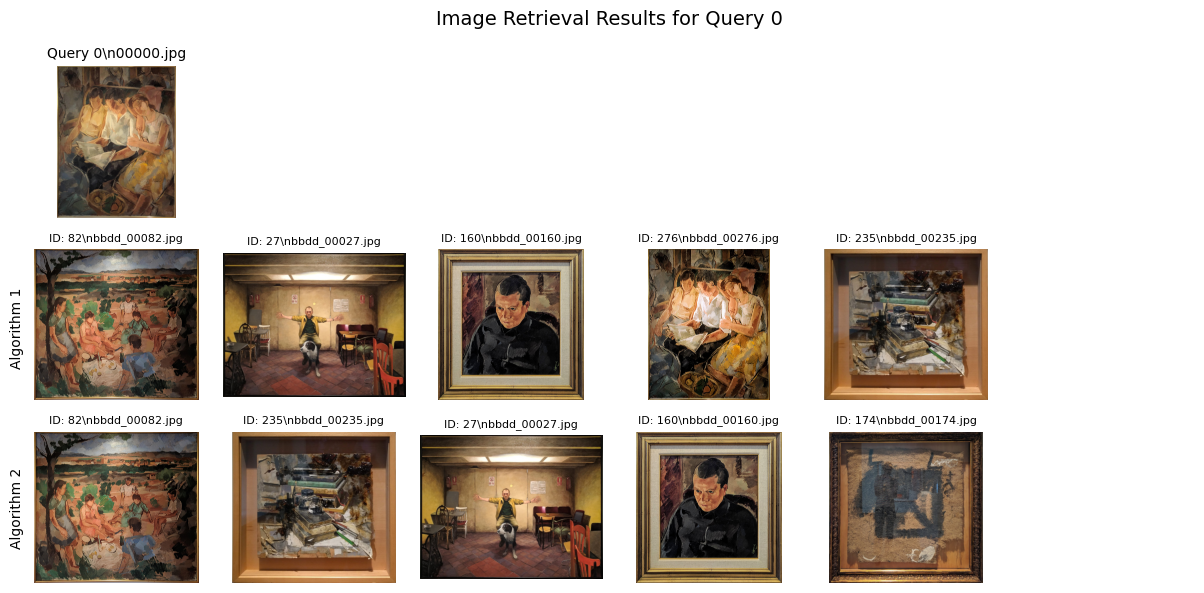

Algorithm 1 - Top 5 results: [82, 27, 160, 276, 235]
Algorithm 2 - Top 5 results: [82, 235, 27, 160, 174]
Query 0: 00000.jpg


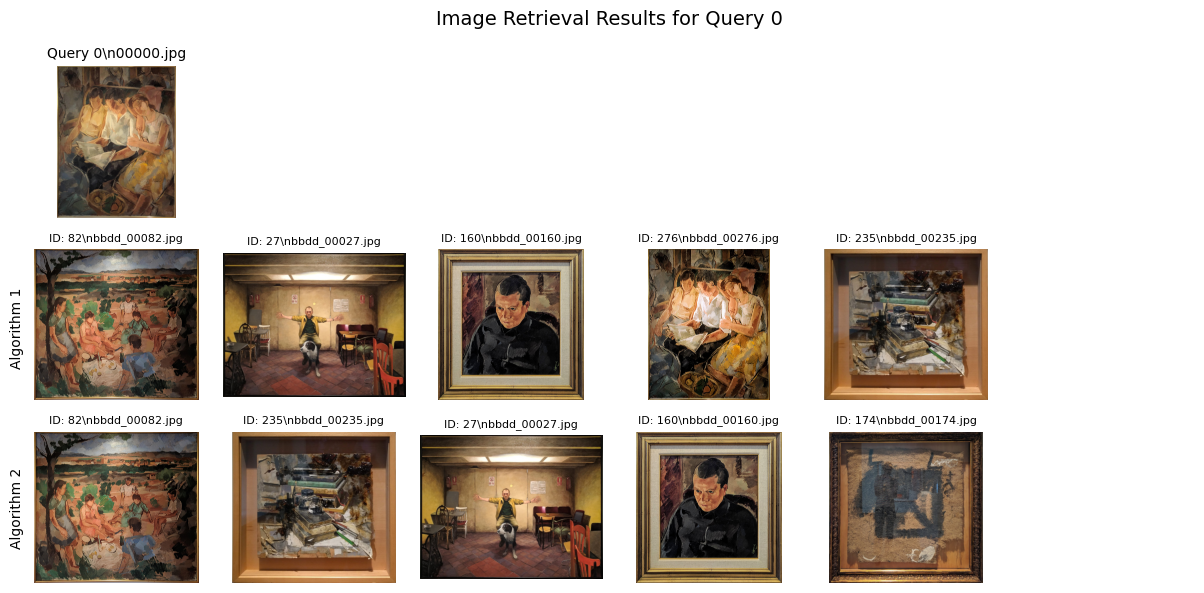

Algorithm 1 - Top 5 results: [82, 27, 160, 276, 235]
Algorithm 2 - Top 5 results: [82, 235, 27, 160, 174]


In [14]:
# Example usage: Show results for different queries
print("Visualizing retrieval results...")
print("Available query indices: 0 to", len(test_images)-1)

# Show results for first few queries
for q_idx in range(min(2, len(test_images))):
    visualize_query_results(test_images, test_directory, train_directory, test_results, query_idx=0, top_n=5)
    print("="*80)

Save the results in pickles

In [15]:

# Create submission pkl files for both methods as requested
for alg_idx in range(len(best_two_results)):
    score, d_pair, weights1, weights2 = best_two_results[alg_idx]
    d1, d2 = d_pair
     
    # Format as list of lists with image IDs
    algorithm_results = test_results[alg_idx]    
    
# Choose the best algorithm (highest MAP@5 score) for final submission
best_algorithm_idx = 0 if best_scores[0] > best_scores[1] else 1
final_results = test_results[best_algorithm_idx]

# Create directories for submission
submission_base = "submission"
method1_dir = os.path.join(submission_base, "method1")
method2_dir = os.path.join(submission_base, "method2")

os.makedirs(method1_dir, exist_ok=True)
os.makedirs(method2_dir, exist_ok=True)

# Create result files for both algorithms
for method_idx in range(len(test_results)):
    method_name = f"method{method_idx + 1}"
    method_dir = os.path.join(submission_base, method_name)
    
    # Get algorithm details
    score, d_pair, weights1, weights2 = best_two_results[method_idx]
    d1, d2 = d_pair
    algorithm_results = test_results[method_idx]
    
    # Create result.pkl file
    result_file = os.path.join(method_dir, "result.pkl")
    
    # Save the results in the required format (list of lists with K=10 results)
    with open(result_file, "wb") as f:
        pickle.dump(algorithm_results, f)
    

# Also create a summary file with method information
summary_info = {
    "team": "Team2",
    "week": 1,
    "dataset": "QST1",
    "methods": {},
    "best_method": best_algorithm_idx + 1,
    "submission_format": "List of lists with K=10 image IDs for each query"
}

for method_idx in range(len(test_results)):
    score, d_pair, weights1, weights2 = best_two_results[method_idx]
    d1, d2 = d_pair
    
    summary_info["methods"][f"method{method_idx + 1}"] = {
        "descriptors": [descriptor_names[d1], descriptor_names[d2]],
        "weights1": weights1,
        "weights2": weights2,
        "optimal_bins": best_bins[method_idx],
        "map5_score": float(best_scores[method_idx]),
        "map1_score": None,  # Would need to be calculated if required
        "num_queries": len(test_results[method_idx]),
        "k_results": K
    }

# Save summary
summary_file = os.path.join(submission_base, "methods_summary.json")
with open(summary_file, "w") as f:
    json.dump(summary_info, f, indent=2)

# Verify the pkl files can be loaded correctly
for method_idx in range(len(test_results)):
    method_name = f"method{method_idx + 1}"
    result_file = os.path.join(submission_base, method_name, "result.pkl")
    
    with open(result_file, "rb") as f:
        loaded_results = pickle.load(f)
    
    print(f"result.pkl for method{method_idx + 1}: {loaded_results}")


result.pkl for method1: [[82, 27, 160, 276, 235, 174, 130, 286, 195, 138], [272, 226, 68, 79, 206, 48, 229, 152, 191, 143], [155, 76, 88, 140, 39, 103, 163, 96, 227, 113], [22, 13, 12, 206, 174, 245, 145, 242, 42, 200], [157, 133, 218, 57, 244, 170, 257, 9, 37, 130], [23, 78, 64, 61, 260, 205, 130, 253, 132, 225], [30, 35, 106, 268, 251, 258, 208, 98, 22, 212], [110, 246, 139, 180, 185, 242, 158, 115, 157, 80], [239, 215, 51, 39, 104, 163, 265, 259, 193, 276], [35, 212, 18, 5, 85, 152, 68, 52, 141, 151], [259, 282, 239, 170, 31, 284, 276, 105, 89, 223], [208, 258, 106, 268, 22, 127, 164, 85, 202, 100], [18, 52, 77, 73, 214, 217, 5, 186, 127, 85], [258, 198, 209, 35, 52, 106, 49, 18, 5, 108], [100, 5, 35, 18, 52, 251, 106, 236, 85, 226], [155, 140, 103, 96, 69, 163, 113, 88, 84, 76], [240, 254, 246, 110, 92, 80, 13, 50, 101, 238], [174, 170, 51, 31, 130, 69, 259, 271, 244, 163], [160, 130, 4, 138, 244, 225, 174, 154, 235, 276], [251, 30, 127, 101, 183, 106, 35, 268, 13, 158], [120, 229,